In [101]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from tqdm import tqdm

fs = 14
mpl.rcParams.update({
    "text.usetex": True,                   # Use LaTeX for all text
    "font.family": "serif",                # Use a serif font
    "font.serif": ["Times", "Computer Modern Roman"],  # Common physics fonts
    "axes.labelsize": fs,                   # Axis labels size
    "axes.titlesize": fs,                   # Title size
    "font.size": fs,                        # General font size
    "legend.fontsize": fs-2,                   # Legend font size
    "xtick.labelsize": fs-2,                   # X-axis tick size
    "ytick.labelsize": fs-2,                   # Y-axis tick size
    "axes.labelpad": 8,
    "axes.titlepad": 8,
    "axes.linewidth": 1.0,                   # Thickness of axes
    "legend.frameon": False,                 # No legend frame
    "xtick.direction": "in",                  # Ticks inside the plot
    "ytick.direction": "in",
    "xtick.major.size": 5,                    # Major tick size
    "ytick.major.size": 5,
    "xtick.minor.size": 3,                    # Minor tick size
    "ytick.minor.size": 3,
    "xtick.minor.visible": True,              # Show minor ticks
    "ytick.minor.visible": True,
    "grid.linestyle": "--",                   # Dashed grid lines
    "grid.alpha": 0.6,                        # Grid transparency
    "grid.color": "gray",                     # Grid color
})

In [ ]:
import warnings
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from copy import deepcopy

class Bloch_Simulator() : 
                                        
    def __init__(self, gamma = 2.675 * 1e8,         # rad/(T*s) 
                    T1 = 1000*1e-3, T2=1000*1e-3,   # s 
                    Mx0 = 0.0,
                    My0 = 0.0,
                    M0 = 1.0, 
                    phi = 0.0, 
                    omega_1 = 0.25 * 1e4,           # 1/s 
                    delta_omega = 0.0,              # 1/s 
                    nz = 1.0,                       # nmb. 
                    tw = 1 * 1e-3,                  # s 
                    G = None, 
                    lower_bound=-np.inf, upper_bound=np.inf
                )  -> None:
        # Constants
        self.delta_x = 2 * 1e-3                     # m
        # Parameters
        self.gamma = gamma
        self.T1 = T1
        self.T2 = T2
        self.Mx0 = Mx0
        self.My0 = My0
        self.M0 = M0
        self.phi = phi
        self.omega_1 = omega_1
        self.delta_omega = delta_omega
        self.nz = nz
        self.tw = tw
        if(G is None) : self.G = 2*np.pi/(self.gamma*self.tw*self.delta_x)
        else :  self.G = G
        # Pulse bounds
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
    
    def set_normal_G(self) : 
        self.G = 2*np.pi/(self.gamma*self.tw*self.delta_x)
    
    def copy(self) : 
        return deepcopy(self)

    def _get_Beff(self, t: float, x: float, apply_sinc: bool)  -> np.ndarray:
        B1 = self._get_omega1(t) / self.gamma
        Beff = np.zeros(3)
        
        Beff[0] += B1*np.cos(self.phi)
        Beff[1] += B1*np.sin(self.phi)
        Beff[2] += self.delta_omega/self.gamma #+ self.G * x

        if(apply_sinc) : Beff *= np.sin(2*np.pi*t/self.tw)/(2*np.pi*t/self.tw)

        if(x) : Beff[2] += self.G * x

        return Beff


    def _get_omega1(self, t: float) -> float: 
        
        if(t >= self.lower_bound and t <= self.upper_bound) : 
            return self.omega_1
        else : 
            return 0
    
    def _diff_eqn(self, t: float, M: list, x: float, apply_sinc: bool) -> np.ndarray: 
        
        
        M = np.array(M)
        Beff = self._get_Beff(t, x, apply_sinc)
        
        # Precession
        dMdt = - self.gamma * np.cross(M, Beff)

        # Relaxation terms
        dMdt[0] += - 1/self.T2 * M[0]
        dMdt[1] += - 1/self.T2 * M[1]
        dMdt[2] += - 1/self.T1 * (M[2] - self.M0)

        return dMdt

    def solve_ivp(self, dt: float, tlin: list, x: float, apply_sinc=True, force_max_step_size=False, *args, **kwargs) : # -> OdeResult
        M0_init = np.array([self.Mx0, self.My0, self.M0])

        solve_kwargs = {
            "fun": self._diff_eqn,
            "y0": M0_init,
            "t_span": (min(tlin), max(tlin)),
            "t_eval": tlin,
            "args": (x,apply_sinc,) + args,
            "rtol": 1e-6,
            "atol": 1e-9
        }
        solve_kwargs.update(kwargs)

        if(force_max_step_size) : solve_kwargs["max_step"] = dt 

        solution = solve_ivp(**solve_kwargs)
                    
        if not solution.success : warnings.warn(solution.message, UserWarning)

        return solution
        

In [28]:
def do_plot(ax, Ls, Mps, Ms) : 
    ax[0].plot(Ls, Mps, '-')
    ax[0].set_xlabel("Position, $x$ (m)")
    ax[0].set_ylabel("Transverse magnetization, $M_{+}$")

    ax[1].plot(Ls, Ms[:,2], '-')
    ax[1].set_xlabel("Position, $x$ (m)")
    ax[1].set_ylabel("Longitudinal magnetization, $M_{z}$")

    for a in ax : a.grid(alpha=0.4)

In [29]:
def find_best_omega(solver, initial_bounds, bounds_step, tlin, dt, tolerance=1e-3) : 
    # Search space
    omegas_test = np.linspace(initial_bounds[0], initial_bounds[1], bounds_step)
    # Variables
    best_omega, best_res = None, None

    copy = solver.copy()

    for omega in omegas_test : 
        copy.omega_1 = omega
        # Run simulation
        solution = copy.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)
        last_value = solution.y[2][-1]
        print(f"Testing omega: {omega}, solver.omega_1: {copy.omega_1},  omega: {omega}, last_value: {last_value}", end='\r')

        # Save best result
        if(best_omega is None) : 
            best_omega = omega
            best_res = last_value
        else : 
            diff = np.abs(best_res) - np.abs(last_value)
            if(diff > 0) : 
                best_omega = omega
                best_res = last_value

    # Warn if tolerance not achieved.
    if(best_res > tolerance) : warnings.warn("Did not reach tolerance.", UserWarning)

    return (best_omega, best_res)

In [30]:
import matplotlib.pyplot as plt

Find the value of b1 that produces a π/2-pulse with nz = 1 and tw = 1 ms.

In [107]:
gamma = 2.675 * 1e8 # rad/(T*s)
T1 = 1000*1e-3
T2 = 1000*1e-3 
M0 = 1.0
phi = np.pi/4
delta_omega = 0.0 

delta_x = 2*1e-3 # mm
tw = 1e-3 # s
nz = 1
bound = 0.5*nz*tw 

G = 2*np.pi/(gamma*tw*delta_x)

omegas = np.linspace(0.26e4, 0.27e4, 1000)

best_omega = None
best_res = None

for omega in omegas : 
    
    solver = Bloch_Simulator(omega_1=omega, lower_bound=-bound, upper_bound=bound)

    dt = 0.0001*1e-3 # s
    tlin = np.arange(-2e-3, 2e-3, dt)
    M0_init = [0.0, 0.0, 1.0]

    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

    if(best_omega is None) : 
        best_omega = omega
        best_res = solution.y[2][-1]
    else : 
        if(np.abs(best_res) > np.abs(solution.y[2][-1])) : 
            best_omega = omega
            best_res = solution.y[2][-1]

In [108]:
print(best_omega, best_res)

2668.2682682682685 -2.1839571006281597e-05


In [31]:
def find_best_omega(solver, initial_bounds, bounds_step, tlin, dt, tolerance=1e-3) : 
    # Search space
    omegas_test = np.linspace(initial_bounds[0], initial_bounds[1], bounds_step)
    # Variables
    best_omega, best_res = None, None

    copy = solver.copy()

    for omega in omegas_test : 
        copy.omega_1 = omega
        
        # Run simulation
        solution = copy.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)
        last_value = solution.y[2][-1]

        # Save best result
        if(best_omega is None) : 
            best_omega = omega
            best_res = last_value
        else : 
            diff = np.abs(best_res) - np.abs(last_value)
            if(diff > 0) : 
                best_omega = omega
                best_res = last_value

    # Warn if tolerance not achieved.
    if(best_res > tolerance) : warnings.warn("Did not reach tolerance.", UserWarning)

    return (best_omega, best_res)


In [43]:
from scipy.optimize import minimize_scalar

def objective(omega, solver, tlin, dt):
    # Set the current omega value in the solver.
    solver.omega_1 = omega
    
    # Run the simulation.
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)
    
    # Minimize w.r.t. last value
    last_value = np.abs(solution.y[2][-1])
    
    return last_value

def find_best_omega(solver, initial_bounds, tlin, dt, tolerance=1e-3):
    # Use minimize_scalar with the bounded method over the initial bounds.
    res = minimize_scalar(objective, args=(solver, tlin, dt), bounds=initial_bounds, method='bounded')
    
    best_omega = res.x
    best_res = res.fun

    # Warn if tolerance not achieved.
    if best_res > tolerance:
        warnings.warn("Did not reach tolerance.", UserWarning)
    
    return best_omega, best_res

In [213]:
tw = 0.5e-3 # s
nz = 1
bound = 0.5*nz*tw 

dt = 0.0001*1e-3 # s
tlin = np.arange(-1e-3, 1e-3, dt)

solver = Bloch_Simulator(omega_1=2000, tw=tw, nz=nz, lower_bound=-bound, upper_bound=bound)
best_omega, best_res = find_best_omega(solver, initial_bounds=[0.2e4, 0.6e4], tlin=tlin, dt=dt)#,bounds_steps = 1000

In [214]:
print(best_omega, best_res)

5332.89915597721 2.3431166945933612e-12


0.0002101676980870886


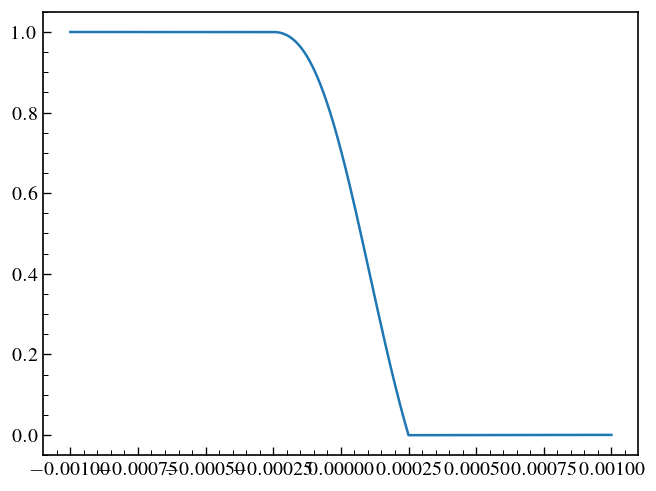

In [204]:
tw = 0.5e-3 # s
nz = 1
bound = 0.5*nz*tw 

dt = 0.0001*1e-3 # s
tlin = np.arange(-1e-3, 1e-3, dt)

solver = Bloch_Simulator(omega_1=3602, lower_bound=-bound, upper_bound=bound)

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

plt.plot(tlin, solution.y[2])
print(solution.y[2][-1])

0.3831396568077038
-0.3691562515316104
-0.19388947567890813


Text(0, 0.5, 'Magnetization, $M_{(x,y,z)}$')

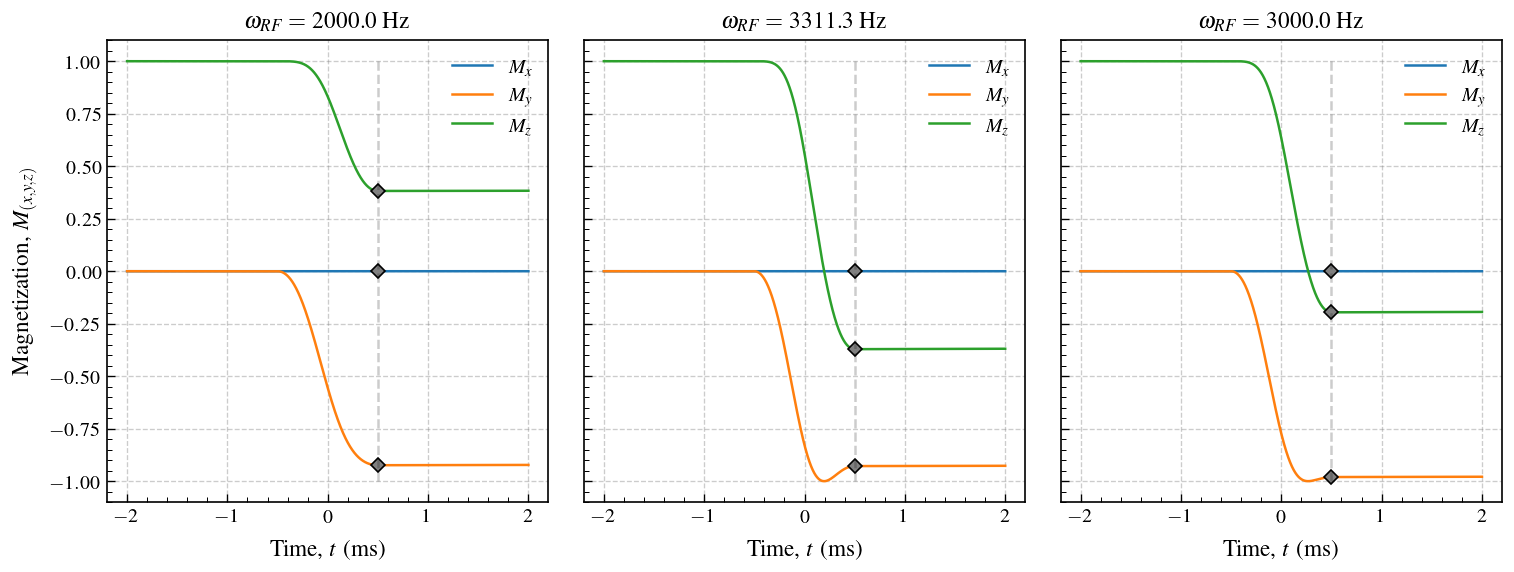

In [149]:
tw = 1.0*1e-3 # s
trf = 1.0 * tw

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

omegas_to_test = [0.2e4, best_omega, 0.3e4]

sols = []
indexs = []

for i,w in enumerate(omegas_to_test) : 
    solver = Bloch_Simulator(omega_1=w, lower_bound=lower_bound, upper_bound=upper_bound, tw=tw)

    M0_init = [0.0, 0.0, 1.0]

    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0.0, apply_sinc=True, force_max_step_size=False)

    print(solution.y[2][-1])

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    sols.append(solution)
    indexs.append(index)

rows, cols = 1, 3
fig, axs = plt.subplots(rows,cols, figsize=(cols*5, rows*5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.08)

tlin *= 1e3
p_args = {'markerfacecolor': 'gray'}
for ax, sol, indx, w in zip(axs, sols, indexs, omegas_to_test) : 
    ax.plot(tlin, sol.y[0], label='$M_x$')
    ax.plot(tlin, sol.y[1], label='$M_y$')
    ax.plot(tlin, sol.y[2], label='$M_z$')
    ax.plot(tlin[indx], sol.y[0][indx], 'kD', **p_args)
    ax.plot(tlin[indx], sol.y[1][indx], 'kD', **p_args)
    ax.plot(tlin[indx], sol.y[2][indx], 'kD', **p_args)
    ax.vlines(x=0.5*trf*1e3, ymin=-1, ymax=1, color='k', linestyle='--', alpha=0.2)
    ax.grid(alpha=0.4)
    ax.set_xlabel("Time, $t$ (ms)")
    ax.set_title(f"$\omega_{{RF}} =$ {w:.5} Hz")
    ax.legend()

axs[0].set_ylabel("Magnetization, $M_{(x,y,z)}$")

In [150]:
fig.savefig(f"./Figures/find_optimal_omega.png", format='png', bbox_inches="tight", dpi=300)

Plot the magnetization profile |M+(x, t)| vs. x at t = trf/2

In [35]:

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

solver = Bloch_Simulator(omega_1=best_omega, lower_bound=-bound, upper_bound=bound)
trf = solver.nz * solver.tw

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)
M0_init = [0.0, 0.0, 1.0]

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


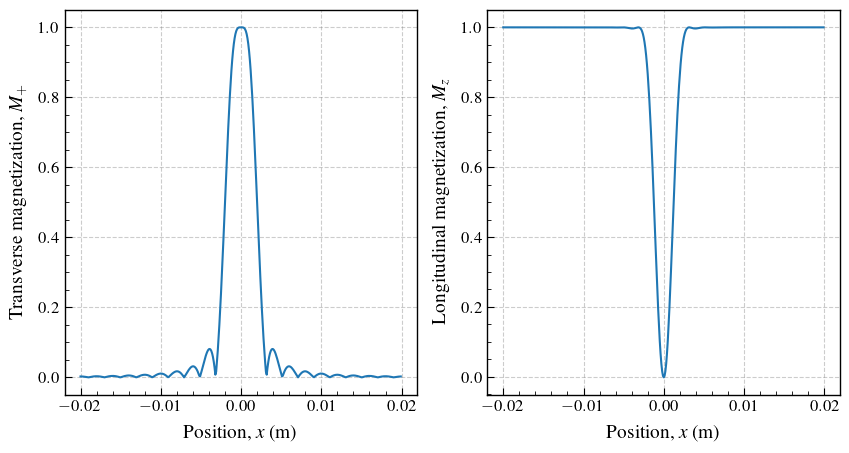

In [36]:
Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)

fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

ax[0].plot(Ls, Mps, '-')
ax[0].set_xlabel("Position, $x$ (m)")
ax[0].set_ylabel("Transverse magnetization, $M_{+}$")

ax[1].plot(Ls, Ms[:,2], '-')
ax[1].set_xlabel("Position, $x$ (m)")
ax[1].set_ylabel("Longitudinal magnetization, $M_{z}$")

for a in ax : a.grid(alpha=0.4)

How is the profile affected when you vary you double or halve the gradient strength

In [105]:
# G = 2*np.pi/(self.gamma*self.tw*self.delta_x)

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

solver.G = solver.G * 2

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


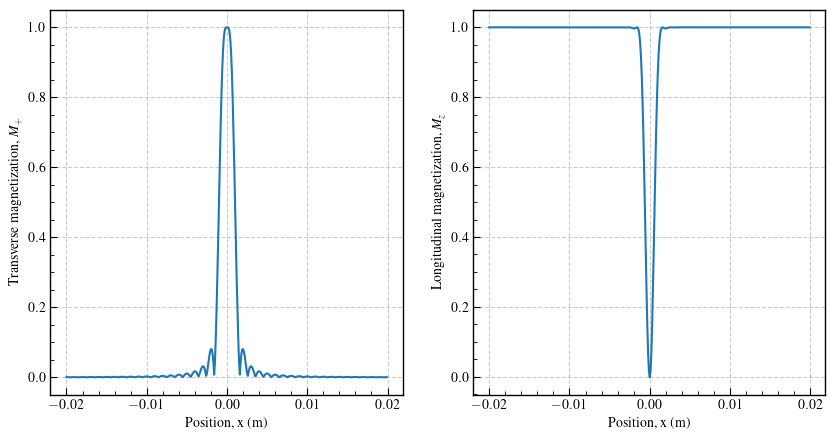

In [106]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)


if we increase G, we spatially hit a smaller region of the "scan" and also have higher frequencies. In a time domain the high frequencies will make a shorter pulse, i.e. a shorter slice. 

In [107]:
solver.set_normal_G()
solver.G = solver.G * 0.5

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


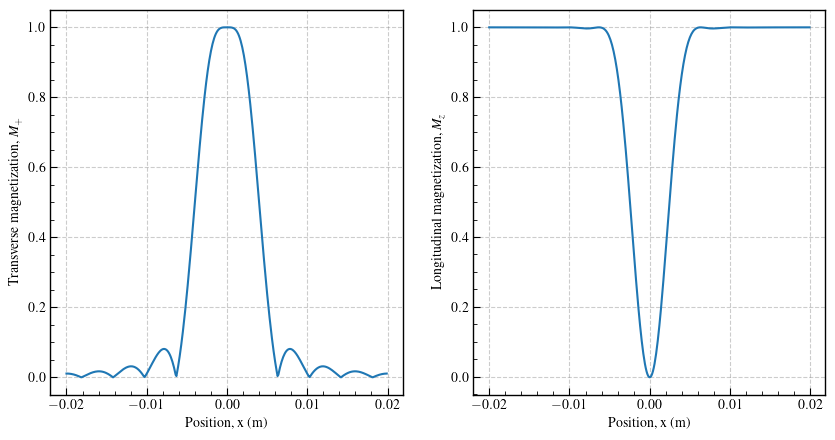

In [108]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)

In [154]:
### FOR NICER PLOTS

#### FIND OPTIMUM OMEGA FOR PI/2

tw = 1*1e-3 # s
nz = 1
trf = nz * tw
lower_bound = -0.5  * trf
upper_bound = 0.5 * trf
dummy_solver = Bloch_Simulator(tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound)
# Reference value of G
stand_G = dummy_solver.G

G_factors = [0.25, 0.5, 1.0, 1.5, 1.75]
best_omegas = []
best_results = []

for G_fact in tqdm(G_factors) : 

    length = 2*1e-2 # m
    Ls = np.arange(-length, length, 0.01e-2)

    dt = 0.0001*1e-3 # s
    tlin = np.arange(-2e-3, 2e-3, dt)

    solver = Bloch_Simulator(tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound, G=stand_G*G_fact)

    best_omega, best_res = find_best_omega(solver, initial_bounds=[0.1e4, 0.9e4], tlin=tlin, dt=dt, tolerance=1e-3)

    best_omegas.append(best_omega)
    best_results.append(best_res)
    print(best_omega, best_res)


 20%|██        | 1/5 [00:01<00:05,  1.48s/it]

2668.23108604514 1.0894281141104762e-08


 40%|████      | 2/5 [00:02<00:03,  1.18s/it]

2668.23108604514 1.0894281141104762e-08


 60%|██████    | 3/5 [00:03<00:02,  1.16s/it]

2668.23108604514 1.0894281141104762e-08


 80%|████████  | 4/5 [00:04<00:01,  1.11s/it]

2668.23108604514 1.0894281141104762e-08


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

2668.23108604514 1.0894281141104762e-08


In [156]:
length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.005e-2)

dt = 0.0001*1e-3 # s

all_Ms = []

for best_omega, G_fact in zip(best_omegas, G_factors) : 

    tw = 1*1e-3     # unit:  s
    nz = 1
    trf = nz * tw

    tlin = np.arange(-0.5*trf, 0.5*trf+dt, dt)

    lower_bound = -0.5  * trf
    upper_bound = 0.5 * trf

    solver = Bloch_Simulator(omega_1=best_omega, tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound, G=G_fact*stand_G)

    curr_Ms = []

    for x in tqdm(Ls) : 
        
        solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

        #index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

        curr_Ms.append( solution.y )

    all_Ms.append(np.array(curr_Ms))


  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [01:17<00:00, 10.36it/s]


In [157]:
#Mps = []
#Mzs = []

all_Mps = []
all_Mz = []

for all_solutions, G_fact in zip(all_Ms, G_factors) : 
    
    tw = 1*1e-3     # unit:  s
    nz = 1
    trf = nz * tw

    tlin = np.arange(-0.5*trf, 0.5*trf+dt, dt)

    index = np.where(np.isclose(tlin, 0.5*trf))[0][0]

    these_Ms = []

    for solution in all_solutions : 

        these_Ms.append( solution[:,index] )
    
    these_Ms = np.array(these_Ms)

    all_Mps.append( np.sqrt( these_Ms[:,0]**2 + these_Ms[:,1]**2 ) )
    all_Mz.append( these_Ms[:,2] )


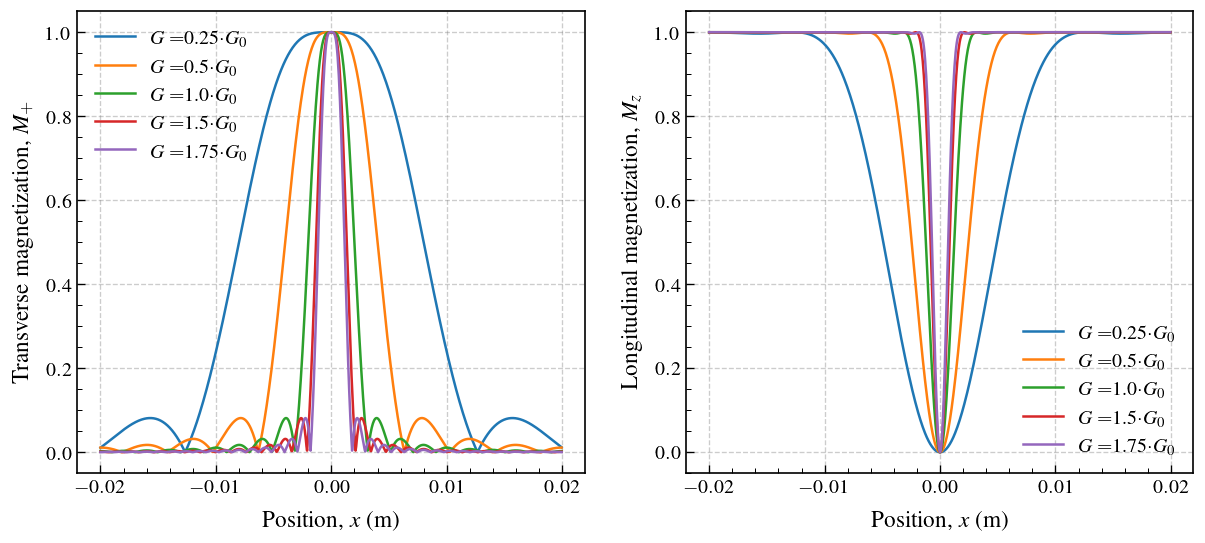

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(2*6, 1*5))

ax[0].set_xlabel("Position, $x$ (m)")
ax[0].set_ylabel("Transverse magnetization, $M_{+}$")

ax[1].set_xlabel("Position, $x$ (m)")
ax[1].set_ylabel("Longitudinal magnetization, $M_{z}$")

for i, (Mps, Mz) in enumerate(zip(all_Mps, all_Mz)) : 

    ax[0].plot(Ls, Mps, '-', label=f'$G =${G_factors[i]}$\cdot G_0$')
    #ax_left.plot(Ls, Mps, '-')

    ax[1].plot(Ls, Mz, '-', label=f'$G =${G_factors[i]}$\cdot G_0$')
    #ax_right.plot(Ls, Mz, '-')

ax[0].legend()
ax[1].legend(loc='lower right')
for a in ax : a.grid(alpha=0.4)

In [159]:
fig.savefig(f"./Figures/various_Gs.png", format='png', bbox_inches="tight", dpi=300)

How would you spatially shift (translate) the slice?

See our drawing. You would change the offset / center frequency of the RF pulse (omega_1). 

How is the profile affected when you vary tw?

You would be capable of performing a larger slice now that the pulse duration is larger.

In [ ]:
#### FIND OPTIMUM OMEGA FOR PI/2

tw = 2*1e-3 # s
trf = 1.0 * tw

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

solver = Bloch_Simulator(tw=tw, lower_bound=lower_bound, upper_bound=upper_bound)

best_omega, best_res = find_best_omega(solver, initial_bounds=[0.1e4, 0.15e4], bounds_step=1000, tlin=tlin, dt=dt, tolerance=1e-3)

print(best_omega, best_res)

1334.3343343343345 -0.00016065929675253005


In [110]:
tw = 2*1e-3 # s
trf = 1.0 * tw

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

solver = Bloch_Simulator(omega_1=best_omega, tw=tw, lower_bound=lower_bound, upper_bound=upper_bound)

Ms = []

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )

print(index)

Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


30000


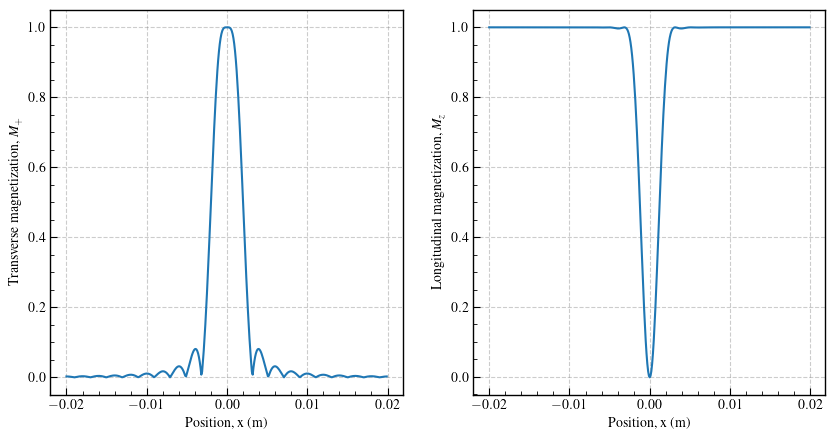

In [111]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)


In [112]:
#### FIND OPTIMUM OMEGA FOR PI/2

tw = 0.5*1e-3 # s
trf = 1.0 * tw

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

solver = Bloch_Simulator(omega_1=best_omega, tw=tw, lower_bound=lower_bound, upper_bound=upper_bound)

best_omega, best_res = find_best_omega(solver, initial_bounds=[0.45e4, 0.65e4], bounds_step=1000, tlin=tlin, dt=dt, tolerance=1e-3)

print(best_omega, best_res)

5336.836836836837 -0.00015880664135806306


In [113]:
tw = 0.5*1e-3 # s
trf = 1.0 * tw

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

solver = Bloch_Simulator(omega_1=0.67e4, tw=tw, lower_bound=lower_bound, upper_bound=upper_bound)

Ms = []

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )

Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


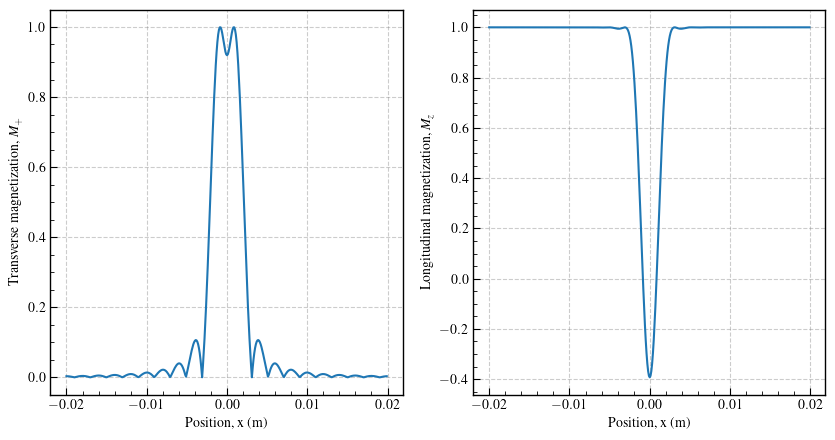

In [114]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)


In [ ]:
# ---------- OLD PLOT --------------

solver.set_normal_G()
solver.tw = 1*1e-3 # s

solver.tw = 0.5*1e-3 # s
trf = solver.nz * solver.tw

solver.lower_bound = -0.5 * trf
solver.upper_bound = 0.5 * trf

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


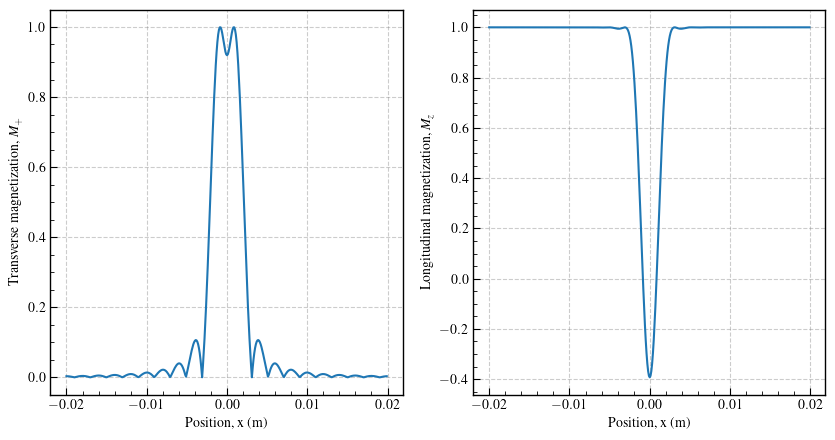

In [116]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)


In [250]:
# FOR NICER PLOTS OF TW

#### FIND OPTIMUM OMEGA FOR PI/2

# Reference tw
tw0 = 1e-3 # s
nz = 1

tw_factors = [0.5, 1.0, 1.5, 2.0]
best_omegas = []
best_results = []

dummy_solver = Bloch_Simulator(tw=1e-3, nz=1, lower_bound=-0.5*1e-3, upper_bound=0.5*1e-3)
# Reference value of G
stand_G = dummy_solver.G

for tw_fact in tqdm(tw_factors) : 

    length = 2*1e-2 # m
    Ls = np.arange(-length, length, 0.01e-2)

    tw = tw0 * tw_fact
    trf = nz * tw

    dt = 0.0001*1e-3 # s
    tlin = np.arange(-2*tw, 2*tw, dt)

    lower_bound = -0.5 * trf
    upper_bound = 0.5 * trf

    solver = Bloch_Simulator(tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound, G=stand_G)

    if tw_fact == tw_factors[-1] : bounds = [0.1e4, 0.4e4]
    else : bounds = [0.1e4, 0.6e4]

    best_omega, best_res = find_best_omega(solver, initial_bounds=bounds, tlin=tlin, dt=dt, tolerance=1e-3)

    best_omegas.append(best_omega)
    best_results.append(best_res)
    print(tw_fact, best_omega, best_res)


 25%|██▌       | 1/4 [00:00<00:02,  1.15it/s]

0.5 5332.899122915382 9.62352045188325e-09


 50%|█████     | 2/4 [00:01<00:02,  1.02s/it]

1.0 2668.231049581261 9.414275394241823e-09


 75%|███████▌  | 3/4 [00:03<00:01,  1.10s/it]

1.5 1780.0093742328502 6.8314596272630104e-09


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

2.0 1335.899635372693 3.3555752577615894e-09


In [251]:
length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.005e-2)

dt = 0.0001*1e-3 # s

all_Ms = []

for best_omega, tw_fact in zip(best_omegas, tw_factors) : 

    tw = tw0 * tw_fact     # unit:  s
    nz = 1
    trf = nz * tw

    tlin = np.arange(-2*tw, 2*tw, dt)

    lower_bound = -0.5  * trf
    upper_bound = 0.5 * trf

    solver = Bloch_Simulator(omega_1=best_omega, tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound, G=stand_G)

    curr_Ms = []

    for x in tqdm(Ls) : 
        
        solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

        #index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

        curr_Ms.append( solution.y )

    all_Ms.append(np.array(curr_Ms))


100%|██████████| 800/800 [03:51<00:00,  3.45it/s]


In [252]:
#Mps = []
#Mzs = []

all_Mps = []
all_Mz = []

for all_solutions, tw_fact in zip(all_Ms, tw_factors) : 
    
    tw = tw0*tw_fact     # unit:  s
    nz = 1
    trf = nz * tw

    tlin = np.arange(-2*tw, 2*tw, dt)

    index = np.where(np.isclose(tlin, 0.5*trf))[0][0]

    these_Ms = []

    for solution in all_solutions : 

        these_Ms.append( solution[:,index] )
    
    these_Ms = np.array(these_Ms)

    all_Mps.append( np.sqrt( these_Ms[:,0]**2 + these_Ms[:,1]**2 ) )
    all_Mz.append( these_Ms[:,2] )


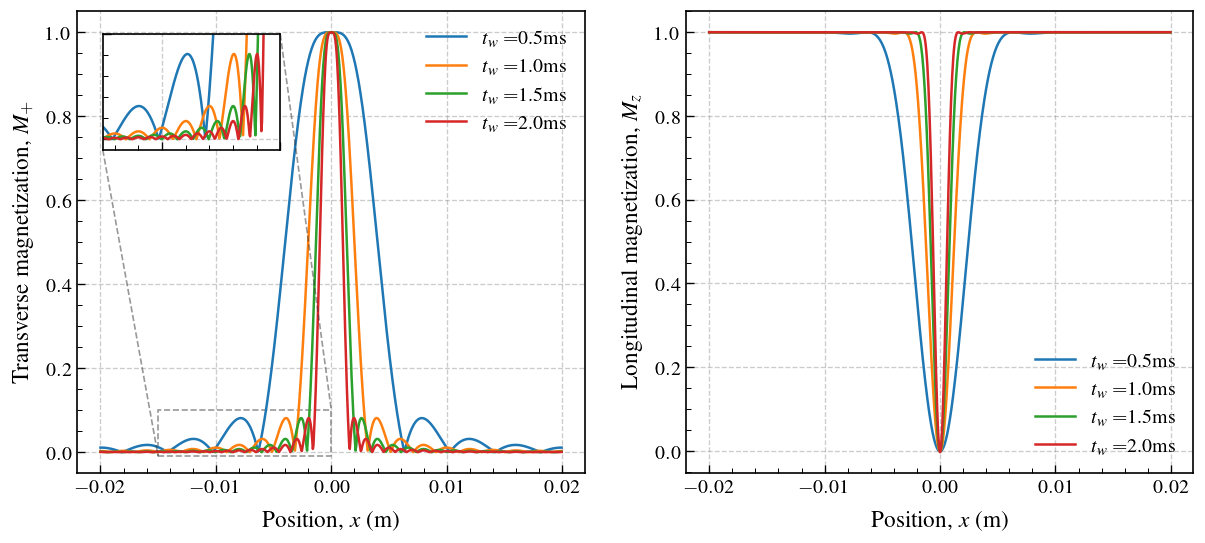

In [272]:
fig, ax = plt.subplots(1,2, figsize=(2*6, 1*5))

ax[0].set_xlabel("Position, $x$ (m)")
ax[0].set_ylabel("Transverse magnetization, $M_{+}$")

ax[1].set_xlabel("Position, $x$ (m)")
ax[1].set_ylabel("Longitudinal magnetization, $M_{z}$")

ax_left = ax[0].inset_axes([0.05, 0.7, 0.35, 0.25])  # (x0, y0, width, height)
ax_left.tick_params(axis='x', labelbottom=False)  # hide x-label text
ax_left.tick_params(axis='y', labelleft=False)    # hide y-label text
mark_inset(ax[0], ax_left, loc1=3, loc2=1, ec="0.2", linestyle="--", alpha=0.5)
ax_left.set_xlim(-0.015, 0.0)
ax_left.set_ylim(-0.01, 0.1)
ax_left.grid(alpha=0.4)

for i, (Mps, Mz) in enumerate(zip(all_Mps, all_Mz)) : 

    ax[0].plot(Ls, Mps, '-', label=f'$t_w =${tw_factors[i]}$ \mathrm{{ms}}$')
    ax_left.plot(Ls, Mps, '-')

    ax[1].plot(Ls, Mz, '-', label=f'$t_w =${tw_factors[i]}$ \mathrm{{ms}}$')
    #ax_right.plot(Ls, Mz, '-')

ax[0].legend()
ax[1].legend(loc='lower right')
for a in ax : a.grid(alpha=0.4)

In [273]:
fig.savefig(f"./Figures/various_tws.png", format='png', bbox_inches="tight", dpi=300)

How is the profile affected when you vary nz?

In [47]:
#### FIND OPTIMUM OMEGA FOR PI/2

tw = 1*1e-3 # s
nz = 10
trf = 1.0 * tw

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

lower_bound = -0.5 * nz * trf
upper_bound = 0.5 * nz * trf

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

solver = Bloch_Simulator(tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound)

best_omega, best_res = find_best_omega(solver, initial_bounds=[0.1e4, 0.9e4], bounds_step=1000, tlin=tlin, dt=dt, tolerance=1e-3)

print(best_omega, best_res)

 25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

2668.23108604514 1.0894281141104762e-08


 50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

3311.289733731125 1.6396289369627337e-09


 75%|███████▌  | 3/4 [00:07<00:02,  2.26s/it]

3311.289733731125 1.6396289369627337e-09


100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

3311.289733731125 1.6396289369627337e-09


In [118]:

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.005e-2)

solver = Bloch_Simulator(omega_1=best_omega, tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound)

Ms = []

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

for x in tqdm(Ls) : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False, rtol=1e-9, atol=1e-9)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )

Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


100%|██████████| 800/800 [03:36<00:00,  3.70it/s]


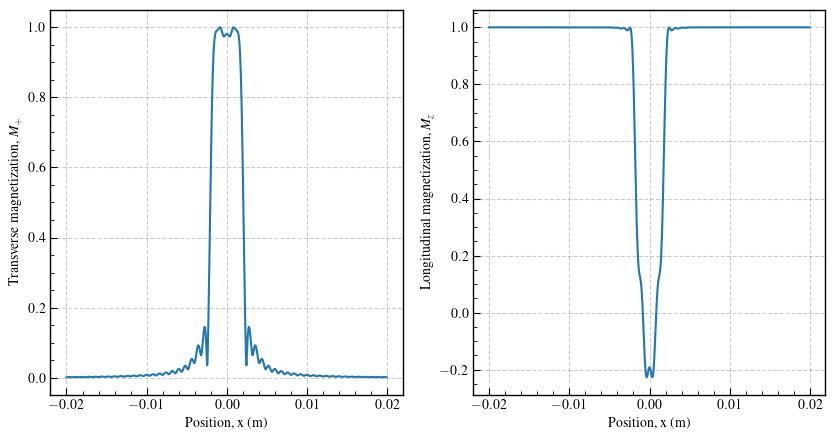

In [119]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

#ax[0].plot(Ls, Mps, '.-')
do_plot(ax, Ls, Mps, Ms)

In [49]:
#### PLOT FOR VARIOUS NZ'S IN SAME FIGURE

#### FIND OPTIMUM OMEGA FOR PI/2

nzs_to_try = [1, 5, 15, 30]
best_omegas = []
best_results = []

for nz in tqdm(nzs_to_try) : 

    tw = 1*1e-3 # s
#    nz = 10
    trf = nz * tw

    length = 2*1e-2 # m
    Ls = np.arange(-length, length, 0.01e-2)

    lower_bound = -0.5  * trf
    upper_bound = 0.5 * trf

    dt = 0.0001*1e-3 # s
    tlin = np.arange(-2e-3, 2e-3, dt)

    solver = Bloch_Simulator(tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound)

    best_omega, best_res = find_best_omega(solver, initial_bounds=[0.1e4, 0.9e4], tlin=tlin, dt=dt, tolerance=1e-3)

    best_omegas.append(best_omega)
    best_results.append(best_res)
    print(best_omega, best_res)



 25%|██▌       | 1/4 [00:01<00:05,  1.86s/it]

2668.23108604514 1.0894281141104762e-08


 50%|█████     | 2/4 [00:03<00:03,  1.56s/it]

3311.289733731125 1.6396289369627337e-09


 75%|███████▌  | 3/4 [00:04<00:01,  1.56s/it]

3311.289733731125 1.6396289369627337e-09


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

3311.289733731125 1.6396289369627337e-09


In [82]:
length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.005e-2)

dt = 0.0001*1e-3 # s

all_Ms = []

for best_omega, nz in zip(best_omegas, nzs_to_try) : 

    tw = 1*1e-3     # unit:  s
    trf = nz * tw

    tlin = np.arange(-0.5*trf, 0.5*trf+dt, dt)

    lower_bound = -0.5  * trf
    upper_bound = 0.5 * trf

    solver = Bloch_Simulator(omega_1=best_omega, tw=tw, nz=nz, lower_bound=lower_bound, upper_bound=upper_bound)

    curr_Ms = []

    for x in tqdm(Ls) : 
        
        solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

        #index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

        curr_Ms.append( solution.y )

    all_Ms.append(np.array(curr_Ms))



100%|██████████| 800/800 [15:58<00:00,  1.20s/it]


In [93]:
#Mps = []
#Mzs = []

all_Mps = []
all_Mz = []

for all_solutions, nz in zip(all_Ms, nzs_to_try) : 
    
    tw = 1*1e-3     # unit:  s
    trf = nz * tw

    tlin = np.arange(-0.5*trf, 0.5*trf+dt, dt)

    index = np.where(np.isclose(tlin, 0.5*trf))[0][0]

    these_Ms = []

    for solution in all_solutions : 

        these_Ms.append( solution[:,index] )
    
    these_Ms = np.array(these_Ms)

    all_Mps.append( np.sqrt( these_Ms[:,0]**2 + these_Ms[:,1]**2 ) )
    all_Mz.append( these_Ms[:,2] )



In [96]:
output_filename = "nz_sim.txt"

with open(output_filename, "w") as f:
    # Loop over each pair of arrays in all_Mps and all_Mz
    for i, (Mps, Mz) in enumerate(zip(all_Mps, all_Mz)):
        f.write(f"Set {i}:\n")
        f.write("Mps: " + " ".join(f"{val:.6f}" for val in Mps) + "\n")
        f.write("Mz:  " + " ".join(f"{val:.6f}" for val in Mz) + "\n")
        f.write("\n")  # blank line between sets

print(f"Data successfully saved to {output_filename}")

Data successfully saved to nz_sim.txt


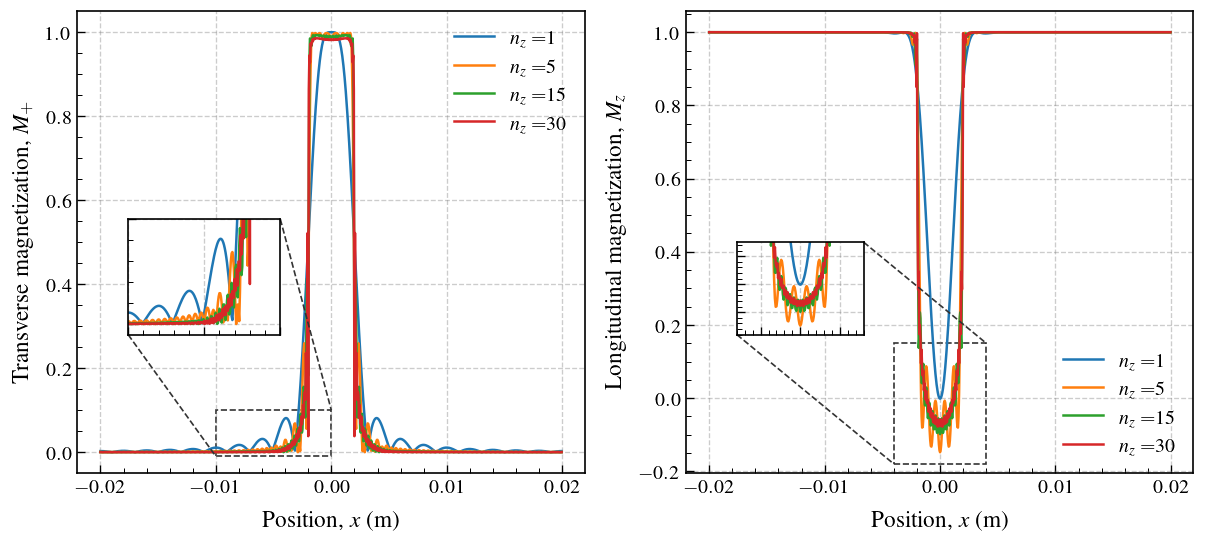

In [137]:
fig, ax = plt.subplots(1,2, figsize=(2*6, 1*5))

ax[0].set_xlabel("Position, $x$ (m)")
ax[0].set_ylabel("Transverse magnetization, $M_{+}$")

ax[1].set_xlabel("Position, $x$ (m)")
ax[1].set_ylabel("Longitudinal magnetization, $M_{z}$")

ax_left = ax[0].inset_axes([0.1, 0.3, 0.3, 0.25])  # (x0, y0, width, height)
ax_left.tick_params(axis='x', labelbottom=False)  # hide x-label text
ax_left.tick_params(axis='y', labelleft=False)    # hide y-label text
mark_inset(ax[0], ax_left, loc1=3, loc2=1, ec="0.2", linestyle="--")
ax_left.set_xlim(-0.010, 0.0)
ax_left.set_ylim(-0.01, 0.1)
ax_left.grid(alpha=0.4)

ax_right = ax[1].inset_axes([0.1, 0.3, 0.25, 0.20])  # (x0, y0, width, height)
ax_right.tick_params(axis='x', labelbottom=False)  # hide x-label text
ax_right.tick_params(axis='y', labelleft=False)    # hide y-label text
mark_inset(ax[1], ax_right, loc1=1, loc2=3, ec="0.2", linestyle="--")
ax_right.set_xlim(-0.004, 0.004)
ax_right.set_ylim(-0.18, 0.15)
ax_right.grid(alpha=0.4)

for i, (Mps, Mz) in enumerate(zip(all_Mps, all_Mz)) : 

    ax[0].plot(Ls, Mps, '-', label=f'$n_z =${nzs_to_try[i]}')
    ax_left.plot(Ls, Mps, '-')

    ax[1].plot(Ls, Mz, '-', label=f'$n_z =${nzs_to_try[i]}')
    ax_right.plot(Ls, Mz, '-')

ax[0].legend()
ax[1].legend(loc='lower right')
for a in ax : a.grid(alpha=0.4)

In [139]:
fig.savefig(f"./Figures/varying_nz.png", format='png', bbox_inches="tight", dpi=300)

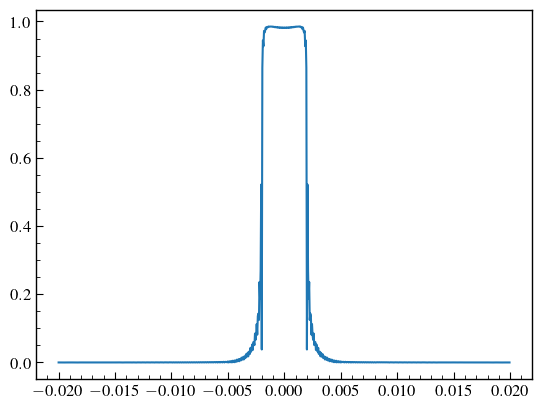

In [91]:
plt.plot(Ls, Mps, '-')
#print(Ms)
#plt.plot(Ls, Ms[:,2])

In [ ]:
# ----------------- OLD PLOT --------------

""" solver.set_normal_G()
solver.tw = 1*1e-3 # s

solver.nz = 1
solver.nz = 2

trf = solver.nz * solver.tw

solver.lower_bound = -0.5 * trf
solver.upper_bound = 0.5 * trf

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)
 """

' solver.set_normal_G()\nsolver.tw = 1*1e-3 # s\n\nsolver.nz = 1\nsolver.nz = 2\n\ntrf = solver.nz * solver.tw\n\nsolver.lower_bound = -0.5 * trf\nsolver.upper_bound = 0.5 * trf\n\nsolution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)\n\nMs = []\n\nfor x in Ls : \n    \n    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)\n\n    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]\n\n    Ms.append( solution.y[:,index] )\n\n\nMs = np.array(Ms)\n\nMps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)\n '

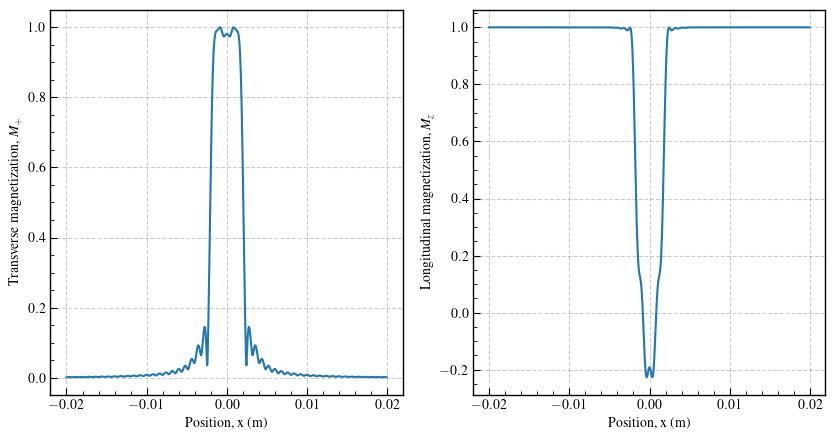

In [121]:
""" fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms) """

small sinc's from B field we now include give more resonant Larmor frequencies and more interaction leading to funky buisness

In [1]:
from skimage.data import shepp_logan_phantom

In [59]:
tw = 1.0*1e-3 # s
trf = 1.0 * tw

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

phantom = shepp_logan_phantom()

phantom_1d = phantom[phantom.shape[0] //2, :]

# Initialize
solver = Bloch_Simulator(Mx0=0.0, My0=0.0, M0=1.0, tw=tw, omega_1=2668.268, lower_bound=lower_bound, upper_bound=upper_bound)

total_length = 20*1e-2  # unit: meter

dt = 1/(total_length * solver.gamma * solver.G) 

#dt = 0.0001*1e-3 # s

N = len(phantom_1d)     # unit: pixel_index

time_window = N//2 * dt

tlin = np.linspace( -1*time_window, 1*time_window, N, endpoint=False)

dx = total_length / N   # unit: meter / pixel_index

dk = 1 / total_length   # unit: 1/meter

In [60]:
print(len(tlin))
print(N)

400
400


In [61]:

ts = None
all_M_complex = []

for index, M0x in enumerate((phantom_1d)) : 

    x = dx * index
    solver.M0x = M0x
    solver.M0 = 1 - M0x
    print(index, '  ', solver.M0x, '  ', solver.M0, end='\r')

    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    if(index == 0) : ts = solution.t

    M_complex = solution.y[0] + 1j * solution.y[1]
    all_M_complex.append(M_complex)

all_M_complex = np.array(all_M_complex)

# Sum over the spatial positions (and multiply by pixel width to approximate integration)
Sts = np.sum(all_M_complex, axis=0) * dx


In [62]:
print(len(Sts))
print(len(phantom_1d))
print(len(tlin))
print(dx)
print(dk)

400
400
400
0.0005
5.0


400
400
400


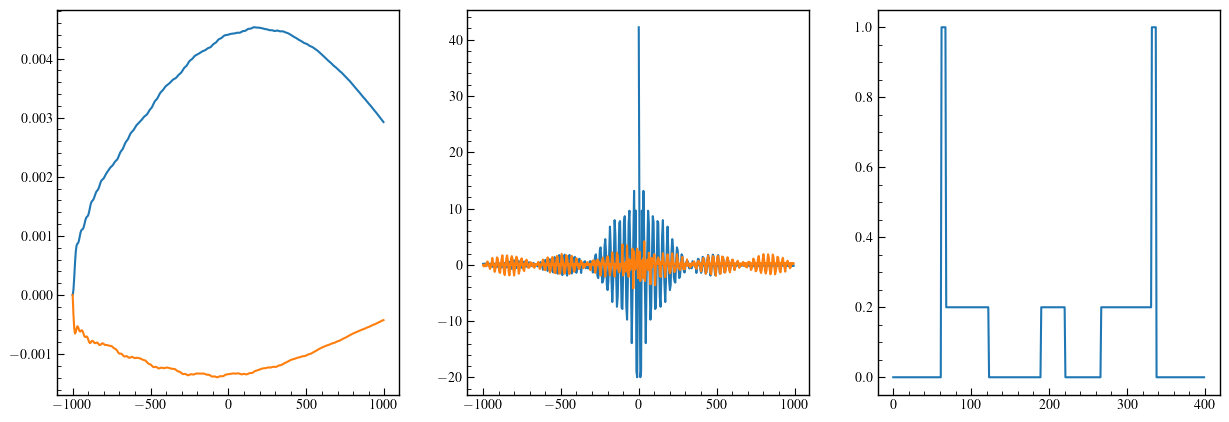

In [65]:
fig, ax = plt.subplots(1,3, figsize=(3*5, 1*5))

k_t = solver.gamma * solver.G * ts

# Phantom FFT:
fft_M0 = np.fft.fft(phantom_1d)
k_array = np.fft.fftfreq(len(phantom_1d), d=dx)  # same points, same spacing

print(len(k_array))
print(len(fft_M0))
print(len(Sts))

ax[0].plot(k_t, np.real(Sts))
ax[0].plot(k_t, np.imag(Sts))

ax[1].plot(k_array, np.real(fft_M0))
ax[1].plot(k_array, np.imag(fft_M0))

ax[2].plot(np.arange(0,len(phantom_1d)), phantom_1d)


Text(0.5, 1.0, 'Phantom 1D slice')

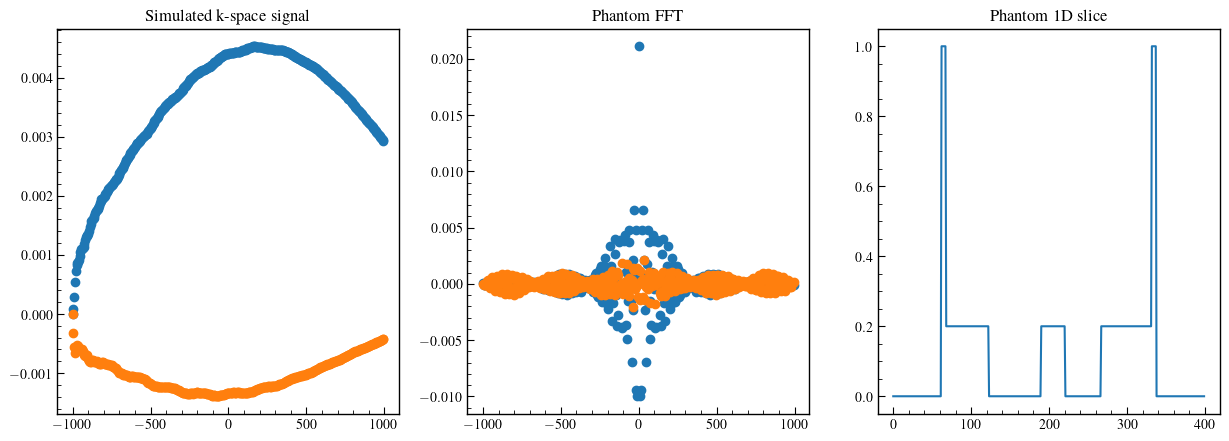

In [67]:
# Create k-space axes
k_sim = solver.gamma * solver.G * tlin
k_sim_shifted = np.fft.fftshift(k_sim)
Sts_shifted = np.fft.fftshift(Sts)

# FFT of the phantom
fft_M0 = np.fft.fft(phantom_1d) * dx  # apply dx if needed for normalization
fft_M0_shifted = np.fft.fftshift(fft_M0)
k_array = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# Plotting
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(k_sim_shifted, np.real(Sts_shifted), 'o', label='Sim Real')
ax[0].plot(k_sim_shifted, np.imag(Sts_shifted), 'o', label='Sim Imag')
ax[0].set_title('Simulated k-space signal')

ax[1].plot(k_array, np.real(fft_M0_shifted), 'o', label='FFT Real')
ax[1].plot(k_array, np.imag(fft_M0_shifted), 'o', label='FFT Imag')
ax[1].set_title('Phantom FFT')

ax[2].plot(np.arange(N), phantom_1d)
ax[2].set_title('Phantom 1D slice')

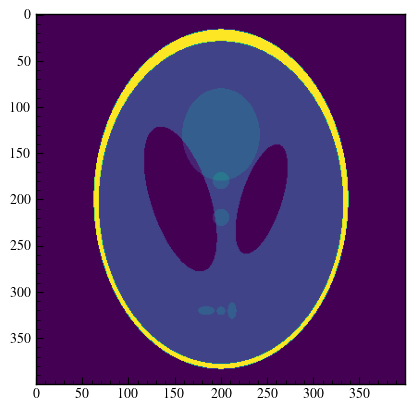

In [152]:
plt.imshow(phantom)

c:\Users\Nicolai\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Nicolai\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


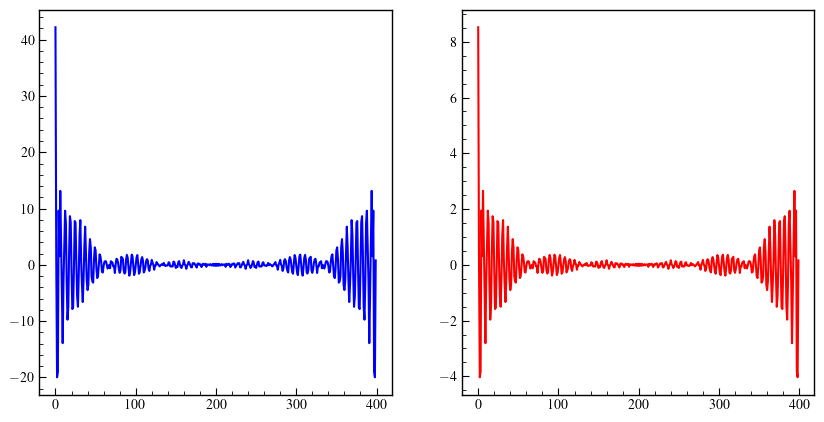

In [156]:
phantom = shepp_logan_phantom()

phantom_1d = phantom[phantom.shape[0] // 2, :]

T2 = 0.01
Te = 16*1e-3    # s

S_k = np.fft.fft(phantom_1d*np.exp(-Te/T2))

fft_M0 = np.fft.fft(phantom_1d)
freq = np.fft.fftfreq(len(phantom_1d))
x = np.linspace(-1, 1, len(phantom_1d))

fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

ax[0].plot(np.arange(0,len(fft_M0),1), fft_M0, 'b-')
ax[1].plot(np.arange(0,len(S_k),1), S_k, 'r-')
#ax[1].plot(x, phantom_1d, 'k--')


by decreasing T_2 we make the exponent negatively larger and therefore e(...) much smaller. So whilst we try to magnetize the brain the spins decay and we lose signal.   

Now take tg = 10 ms, M0(x) = 1 and take T2(x) = 15 ms+ax, with a = .5ms/cm and take Fourier
transform of your signal. What are we seeing? This is a sequence to generate T2 contrast.